# Exercise: Simulating the Spread of a Contagious Disease

In this exercise, you will create a simple spatial simulation of a contagious disease spreading in a population of individuals at RUC. The goal is to model the movement and infection dynamics of 100 individuals. The code can be rather simular to the random walk cofishop code. You will visualize the simulation using folium and a matplotlib pyplot.

Model Assumptions

    Agents (People) are spawned randomlt arround a point at ehe center of RUC. From there the can move randoimly in step sizes up to 10 m.
    Each agent starts as healthy (green).
    a initial percentage 10 is initially infected (red).
    Infected agents:
        Can transmit the disease to nearby agents (within 20 meters).
        Become contagious in the step after they where infected.
        Recover after 5 time units.
        remain immune (blue) for 10 time units after being infectet abd  turning healthy (green) again.
    The simulation runs for a set number of time steps (50), track the number of healthy, infected, and immune agents at each step.

Tasks

    Implement a class Person to model the behavior of an agent.
        Movement of agents.
        Infection and recovery process.
    
    Visualization each step on a folium map.
    Storing state history.
    Run the simulation and analyze the results.




In [1]:
import random
import folium
import time
import math
from pyproj import Transformer
from shapely.geometry import Point
from IPython.display import display, clear_output
import matplotlib.pyplot as plt


In [2]:
# ---- Coordinate Transformers (WGS84 <-> EPSG:25832) ----
wgs_utm = Transformer.from_crs("EPSG:4326", "EPSG:25832", always_xy=True)
utm_wgs = Transformer.from_crs("EPSG:25832", "EPSG:4326", always_xy=True)


In [3]:
# ---- Constants ----
STEP_SIZE = 10  # Max step size (meters)
INFECTION_RADIUS = 50  # Transmission distance (meters)
SPAWN_RADIUS = 250  # Initial spawn radius (meters)
TOTAL_STEPS = 50  # Number of simulation steps
INFECTION_PROB = 0.5  # Probability of infection when in range
INITIAL_INFECTED_PCT = 0.1  # Procentage  of initial infected people

# Time-based states
RECOVERY_TIME = 5  # Time units in which a person is infected
IMMUNE_TIME = 10  # Time units after infection where the user is immun

# ---- Spawn Center ----
CENTER_LON, CENTER_LAT = 12.13975, 55.65313
CENTER_X, CENTER_Y = wgs_utm.transform(CENTER_LON, CENTER_LAT)


In [6]:
# Define the Person class

class Person:
    def __init__(self,state):
        """Initialize a person within 500m of the center in UTM coordinates."""
        angle = random.uniform(0, 2 * math.pi)
        radius = random.uniform(0, SPAWN_RADIUS)
        x = CENTER_X + radius * math.cos(angle)
        y = CENTER_Y + radius * math.sin(angle)
        self.location = Point(x, y) # create a sharply Point object
        self.state = state  # "healthy", "infected", "immune"
        self.infection_time = 0  # Track infection start time only relevant if not healthy

# Define the move and infection behaviour
    def move(self,step, people):
        """Move randomly within the UTM space."""
        dx = (random.random() - 0.5) * STEP_SIZE
        dy = (random.random() - 0.5) * STEP_SIZE
        self.location = Point(self.location.x + dx, self.location.y + dy)

        # Check if they should a person is infectious and was not infected in this time step
        if self.state == "infected" and step != self.infection_time: # ensure you do not pass on the decise emidiatly
            for person in people:
                if person.state == "healthy" and person.location.distance(self.location) < INFECTION_RADIUS and random.random() < INFECTION_PROB:
                    person.state = "infected"
                    person.infection_time = step
            if step >= self.infection_time + RECOVERY_TIME:
                self.state = "immune"
        elif self.state == "immune" and step >= self.infection_time + IMMUNE_TIME:
            self.state = "healthy"  # Immunity wears off

# ---- Initialize People ----
people = []
for person in range(100):
    if random.random() < INITIAL_INFECTED_PCT:
        people.append(Person("infected"))
    else:
        people.append(Person("healthy"))


# ---- State Tracking ----
history = [[],[],[],[]]  # Stores time,counts of healthy, infected, and immune over time
healthy_count = 0
infected_count = 0
immune_count = 0
for person in people:
    if person.state == "healthy":
        healthy_count += 1
    elif person.state == "infected":
        infected_count += 1
    elif person.state == "immune":
        immune_count += 1

# Store in history as a list
history[0].append(0)
history[1].append(healthy_count)
history[2].append(infected_count)
history[3].append(immune_count)

# ---- Simulation Loop ----
for step in range(TOTAL_STEPS):
    clear_output(wait=True)  # Clear previous output

    # Move all people
    for person in people:
        person.move(step, people)


    # Count the number of people in each state
    healthy_count = 0
    infected_count = 0
    immune_count = 0

    for person in people:
        if person.state == "healthy":
            healthy_count += 1
        elif person.state == "infected":
            infected_count += 1
        elif person.state == "immune":
            immune_count += 1

    # Store in history as a list
    history[0].append(step)
    history[1].append(healthy_count)
    history[2].append(infected_count)
    history[3].append(immune_count)


    # ---- Create a Folium Map ----
    map_center = utm_wgs.transform(CENTER_X, CENTER_Y)
    m = folium.Map(location=map_center[::-1], zoom_start=16)

    # Add persons to map
    for person in people:
        lon, lat = utm_wgs.transform(person.location.x, person.location.y)
        if person.state == "healthy":
            color = "green"
        elif person.state == "infected":
            color = "red"
        elif person.state == "immune":
            color = "blue"
        folium.CircleMarker(
            location=[lat, lon], radius=5, color=color, fill=True, fill_color=color, fill_opacity=0.7
        ).add_to(m)

    # Display map
    display(m)
    print(f"Step {step}: Healthy={healthy_count}, Infected={infected_count}, Immune={immune_count}")
    time.sleep(0.5)  # Pause before next step


Step 49: Healthy=100, Infected=0, Immune=0


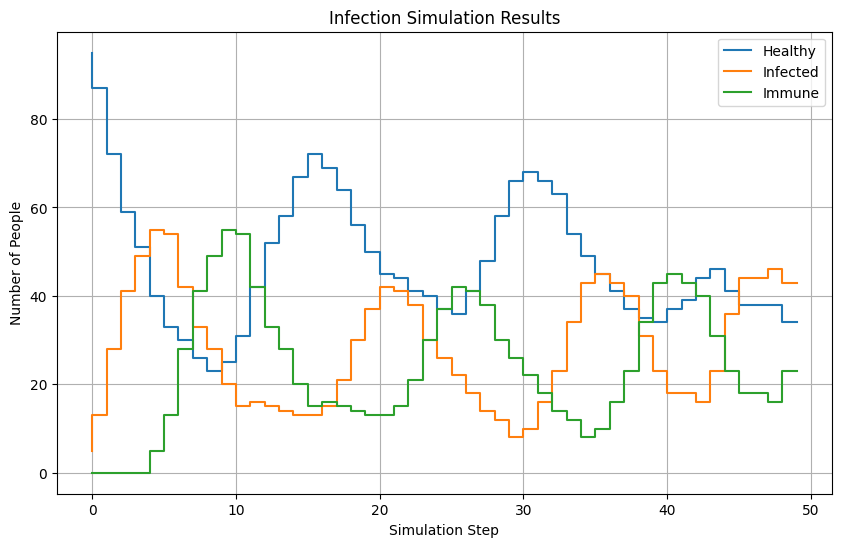

In [5]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.step(history[0], history[1], label='Healthy')
plt.step(history[0], history[2], label='Infected')
plt.step(history[0], history[3], label='Immune')

# Customize the plot
plt.xlabel('Simulation Step')
plt.ylabel('Number of People')
plt.title('Infection Simulation Results')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
